In [ ]:
#before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set harware accelarotor as GPU)
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install face_recognition

In [ ]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition

In [ ]:
# Function to check if the video is corrupted or not.
def validate_video(vid_path, train_transforms):
    transform = train_transforms
    count = 20
    video_path = vid_path
    frames = []
    a = int(100 / count)
    first_frame = np.random.randint(0, a)
    for i, frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if len(frames) == count:
            break
    frames = torch.stack(frames)
    frames = frames[:count]
    return frames

In [ ]:
# Function to extract frames from video
def frame_extract(path):
    vidObj = cv2.VideoCapture(path)
    success = 1
    while success:
        success, image = vidObj.read()
        if success:
            yield image


In [ ]:
### **Cell 4: Data Transformation Setup**
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

video_files = (glob.glob('/content/drive/Shareddrives/deepfakedetect/deepfakedetect/FF_Face_only_data/*.mp4') +
              glob.glob('/content/drive/Shareddrives/deepfakedetect/deepfakedetect/DFDC_FAKE_Face_only_data/*.mp4') +
              glob.glob('/content/drive/Shareddrives/deepfakedetect/deepfakedetect/DFDC_REAL_Face_only_data/*.mp4'))
print("Total number of videos:", len(video_files))

Total number of videos: 5282


In [ ]:
### **Cell 5: Video Corruption Check**
count = 0
for i in video_files:
    try:
        count += 1
        print(count)
        validate_video(i, train_transforms)
    except:
        print("Number of videos processed:", count, "Remaining:", (len(video_files) - count))
        print("Corrupted video is:", i)
        continue
print((len(video_files) - count))

Streaming output truncated to the last 5000 lines.
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
5

In [ ]:
### **Cell 6: Dataset Class Definition**
import pandas as pd
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=10, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        label = self.labels.iloc[self.labels.loc[self.labels["file"] == video_path.split('/')[-1]].index.values[0], 1]
        label = 0 if label == 'FAKE' else 1

        for i, frame in enumerate(self.frame_extract(video_path)):
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            if len(frames) == self.sequence_length:
                break

        # Truncate or pad the frames to the required sequence length
        if len(frames) < self.sequence_length:
            padding = [torch.zeros_like(frames[0]) for _ in range(self.sequence_length - len(frames))]
            frames.extend(padding)
        elif len(frames) > self.sequence_length:
            frames = frames[:self.sequence_length]

        frames = torch.stack(frames)
        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image


In [ ]:
### **Cell 7: Model Definition (Enhanced for Novelty)**
from torch import nn
from torchvision import models

class EnhancedModel(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(EnhancedModel, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)  # Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(2048, 1024)
        self.linear2 = nn.Linear(1024, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        x = self.dp1(self.relu(self.linear1(torch.mean(x_lstm, dim=1))))
        return fmap, self.dp2(self.linear2(x))

In [ ]:
### **Cell 8: Initialize Model and Optimizers**
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, loss function, and scheduler
model = EnhancedModel(2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

### **Cell 9: DataLoader Setup**
from sklearn.model_selection import train_test_split

header_list = ["file", "label"]
labels = pd.read_csv('/content/drive/Shareddrives/deepfakedetect/deepfakedetect/metadata.csv', names=header_list)

train_videos, valid_videos = train_test_split(video_files, test_size=0.2, random_state=42)

train_data = VideoDataset(train_videos, labels, sequence_length=10, transform=train_transforms)
val_data = VideoDataset(valid_videos, labels, sequence_length=10, transform=train_transforms)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
### **Cell 10: AverageMeter Class Definition**
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
### **Cell 11: Training Function**
from torch.autograd import Variable
import sys

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()

    for i, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        loss.backward()
        optimizer.step()

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
            % (epoch, num_epochs, i, len(data_loader), losses.avg, accuracies.avg)
        )
    return losses.avg, accuracies.avg

In [ ]:
### **Cell 12: Training Loop and Plot Display**
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size

def plot_loss(train_loss_avg, val_loss_avg, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_loss_avg, 'g', label='Training loss')
    plt.plot(epochs, val_loss_avg, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracy, val_accuracy, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.ylabel('Actual label', size=20)
    plt.xlabel('Predicted label', size=20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    print("Calculated Accuracy", calculated_acc * 100)

num_epochs = 20
train_loss_avg = []
val_loss_avg = []
train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    scheduler.step()
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(valid_loader.dataset)
    val_acc = val_corrects.double() / len(valid_loader.dataset)
    val_loss_avg.append(val_loss)
    val_accuracy.append(val_acc.item() * 100)

    print(f"\nEpoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")



[Epoch 0/20] [Batch 1056 / 1057] [Loss: 0.668966, Acc: 59.55%]
Epoch 1/20, Train Loss: 0.6690, Train Acc: 59.55%, Val Loss: 0.5681, Val Acc: 0.71%
[Epoch 1/20] [Batch 1056 / 1057] [Loss: 0.621062, Acc: 68.76%]
Epoch 2/20, Train Loss: 0.6211, Train Acc: 68.76%, Val Loss: 0.5626, Val Acc: 0.72%
[Epoch 2/20] [Batch 1056 / 1057] [Loss: 0.581568, Acc: 72.17%]
Epoch 3/20, Train Loss: 0.5816, Train Acc: 72.17%, Val Loss: 0.5206, Val Acc: 0.74%
[Epoch 3/20] [Batch 1056 / 1057] [Loss: 0.535020, Acc: 75.57%]
Epoch 4/20, Train Loss: 0.5350, Train Acc: 75.57%, Val Loss: 0.5015, Val Acc: 0.75%
[Epoch 4/20] [Batch 1056 / 1057] [Loss: 0.508035, Acc: 77.94%]
Epoch 5/20, Train Loss: 0.5080, Train Acc: 77.94%, Val Loss: 0.4506, Val Acc: 0.79%
[Epoch 5/20] [Batch 1056 / 1057] [Loss: 0.437493, Acc: 82.93%]
Epoch 6/20, Train Loss: 0.4375, Train Acc: 82.93%, Val Loss: 0.4047, Val Acc: 0.81%
[Epoch 6/20] [Batch 1056 / 1057] [Loss: 0.382812, Acc: 86.20%]
Epoch 7/20, Train Loss: 0.3828, Train Acc: 86.20%, Val 

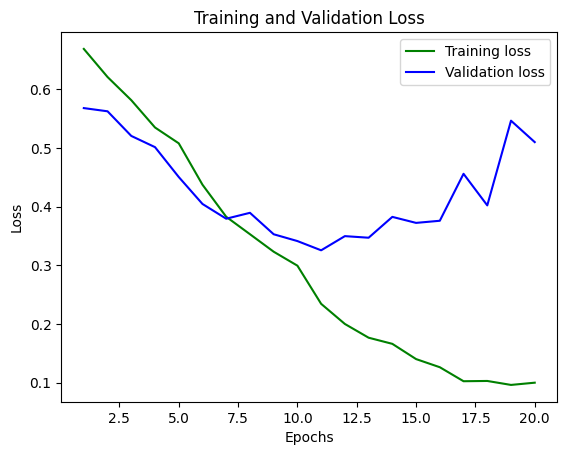

None

In [ ]:
# Plotting loss and accuracy curves
display(plot_loss(train_loss_avg, val_loss_avg, num_epochs))


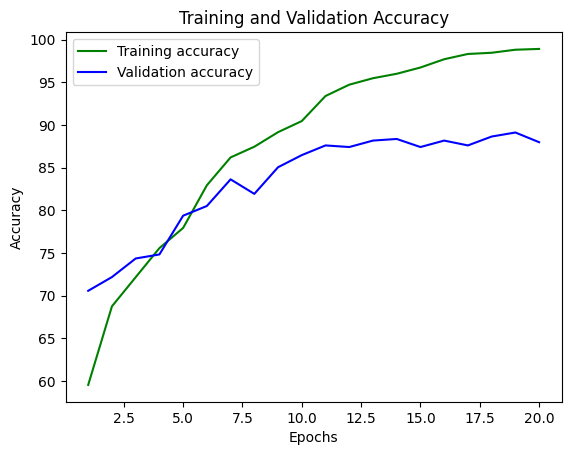

None

In [ ]:
display(plot_accuracy(train_accuracy, val_accuracy, num_epochs))



True positive =  451
False positive =  57
False negative =  70
True negative =  479




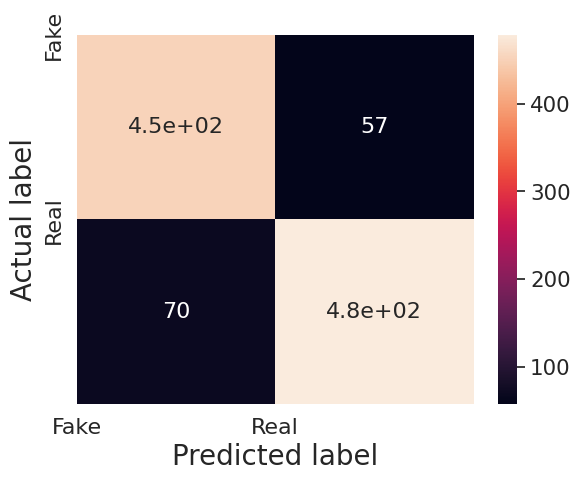

Calculated Accuracy 87.9848628192999


None

In [ ]:

# Confusion matrix
display(print_confusion_matrix(val_labels, val_preds))

In [ ]:

### **Cell 13: Save the Model**
torch.save(model.state_dict(), '/content/finaldfd50.pt')

